In [1]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 62.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 76.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 118.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 28.2 MB/s eta 0:00:00


In [1]:
import glob
import os
from multiprocessing import Pool
from pathlib import Path
import pickle

import h5py
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hdmf_zarr import NWBZarrIO

import utils.new_preprocess as nwp
import utils.nwb_dict_utils as nwb_utils

In [2]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True

In [3]:
def RMSE(x,y):
    return np.sqrt(np.mean((x-y)**2, -1))

def bias(x,y):
    return np.mean(x-y, -1)

def std_of_diff(x,y):
    return np.std(x-y, -1)

In [4]:
parents = sorted(glob.glob("/data/photometry/vary*"))
parents

['/data/photometry/vary_a_max',
 '/data/photometry/vary_a_power',
 '/data/photometry/vary_attenuation',
 '/data/photometry/vary_b_bright',
 '/data/photometry/vary_b_fast',
 '/data/photometry/vary_b_inf',
 '/data/photometry/vary_b_slow',
 '/data/photometry/vary_corr_s',
 '/data/photometry/vary_decay',
 '/data/photometry/vary_motion_power',
 '/data/photometry/vary_noise_std',
 '/data/photometry/vary_t_bright',
 '/data/photometry/vary_t_fast',
 '/data/photometry/vary_t_slow']

In [5]:
def evaluate(parent):
    perf = []
    params = []
    vary = parent.split('/')[-1][5:]
    for nwb_file in sorted(glob.glob(f"{parent}/*/*.nwb")):
        print(f"Processing NWB file: {nwb_file}")
        p = pd.read_csv(Path(nwb_file).parent / "parameters.csv", delimiter=",", index_col=0)
        p = list(p[vary])
        params.append([p[:3], p[3:6]])
        with h5py.File(Path(nwb_file).parent / 'groundtruth.h5') as file:
            dFF_gt = [file[f'fiber{f}']['dff'][:] for f in (0,1)]

        with NWBZarrIO(path=nwb_file, mode="r") as io:
            nwb = io.read()
            # convert nwb to dataframe
            df_from_nwb = nwb_utils.nwb_to_dataframe(nwb)
            # add the session column
            filename = Path(nwb_file).name
            session_name = filename.split(".")[0].split("FIP_")[1]
            df_from_nwb.insert(0, "session", session_name)
            # now pass the dataframe through the preprocessing function:
            df_fip_pp_nwb, df_PP_params = nwp.batch_processing_new(df_fip=df_from_nwb)
            # calculate performance measures
            tmp = []
            for pre in ("poly", "exp", "bright"):
                df = df_fip_pp_nwb[df_fip_pp_nwb["preprocess"]==pre]
                dFF = np.array([[df[(df["channel"] == ch) & (df["fiber_number"] == fiber)]["signal"]
                                 for ch in ['Iso', 'G', 'R']] for fiber in df_fip_pp_nwb["fiber_number"].unique()])
                tmp.append([RMSE(dFF, dFF_gt), bias(dFF, dFF_gt), std_of_diff(dFF, dFF_gt)])
            perf.append(tmp)

    return (np.array(params), # indices: expId, fiber, channel
            np.array(perf))   # indices: expId, method, performance_measure, fiber, channel

In [6]:
%%time
# %%capture
results = Pool(int(os.environ['CO_CPUS'])).map(evaluate, parents)

Processing NWB file: /data/photometry/vary_a_max/FIP_000140_2024-08-06_10-01-07/FIP_000140_2024-08-06_10-01-07.nwbProcessing NWB file: /data/photometry/vary_a_power/FIP_000156_2024-08-06_10-01-19/FIP_000156_2024-08-06_10-01-19.nwb

Processing NWB file: /data/photometry/vary_corr_s/FIP_000164_2024-08-06_10-01-25/FIP_000164_2024-08-06_10-01-25.nwb
Processing NWB file: /data/photometry/vary_b_inf/FIP_000000_2024-08-06_09-59-21/FIP_000000_2024-08-06_09-59-21.nwbProcessing NWB file: /data/photometry/vary_b_fast/FIP_000028_2024-08-06_09-59-42/FIP_000028_2024-08-06_09-59-42.nwb
Processing NWB file: /data/photometry/vary_attenuation/FIP_000112_2024-08-06_10-00-46/FIP_000112_2024-08-06_10-00-46.nwbProcessing NWB file: /data/photometry/vary_b_bright/FIP_000042_2024-08-06_09-59-53/FIP_000042_2024-08-06_09-59-53.nwbProcessing NWB file: /data/photometry/vary_b_slow/FIP_000014_2024-08-06_09-59-32/FIP_000014_2024-08-06_09-59-32.nwb





/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/caps

Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged 

/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Processing NWB file: /data/photometry/vary_b_bright/FIP_000043_2024-08-06_09-59-54/FIP_000043_2024-08-06_09-59-54.nwb
Processing NWB file: /data/photometry/vary_b_slow/FIP_000015_2024-08-06_09-59-33/FIP_000015_2024-08-06_09-59-33.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/caps

Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_fast/FIP_000029_2024-08-06_09-59-43/FIP_000029_2024-08-06_09-59-43.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_inf/FIP_000001_2024-08-06_09-59-22/FIP_000001_2024-08-06_09-59-22.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_a_power/FIP_000157_2024-08-06_10-01-20/FIP_000157_2024-08-06_10-01-20.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_a_max/FIP_000141_2024-08-06_10-01-08/FIP_000141_2024-08-06_10-01-08.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_attenuation/FIP_000114_2024-08-06_10-00-47/FIP_000114_2024-08-06_10-00-47.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_corr_s/FIP_000166_2024-08-06_10-01-27/FIP_000166_2024-08-06_10-01-27.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000016_2024-08-06_09-59-34/FIP_000016_2024-08-06_09-59-34.nwb
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_inf/FIP_000002_2024-08-06_09-59-23/FIP_000002_2024-08-06_09-59-23.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000044_2024-08-06_09-59-55/FIP_000044_2024-08-06_09-59-55.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Processing NWB file: /data/photometry/vary_b_fast/FIP_000030_2024-08-06_09-59-44/FIP_000030_2024-08-06_09-59-44.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_a_power/FIP_000158_2024-08-06_10-01-21/FIP_000158_2024-08-06_10-01-21.nwb
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_attenuation/FIP_000115_2024-08-06_10-00-48/FIP_000115_2024-08-06_10-00-48.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_a_max/FIP_000142_2024-08-06_10-01-08/FIP_000142_2024-08-06_10-01-08.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Processing NWB file: /data/photometry/vary_corr_s/FIP_000167_2024-08-06_10-01-27/FIP_000167_2024-08-06_10-01-27.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:158: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000017_2024-08-06_09-59-34/FIP_000017_2024-08-06_09-59-34.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000045_2024-08-06_09-59-55/FIP_000045_2024-08-06_09-59-55.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_inf/FIP_000003_2024-08-06_09-59-24/FIP_000003_2024-08-06_09-59-24.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_fast/FIP_000031_2024-08-06_09-59-45/FIP_000031_2024-08-06_09-59-45.nwb
Processing NWB file: /data/photometry/vary_a_power/FIP_000159_2024-08-06_10-01-21/FIP_000159_2024-08-06_10-01-21.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/caps

Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_corr_s/FIP_000168_2024-08-06_10-01-28/FIP_000168_2024-08-06_10-01-28.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 44 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 43 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_a_max/FIP_000143_2024-08-06_10-01-09/FIP_000143_2024-08-06_10-01-09.nwb
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000046_2024-08-06_09-59-56/FIP_000046_2024-08-06_09-59-56.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_attenuation/FIP_000116_2024-08-06_10-00-49/FIP_000116_2024-08-06_10-00-49.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_inf/FIP_000004_2024-08-06_09-59-24/FIP_000004_2024-08-06_09-59-24.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/caps

Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000018_2024-08-06_09-59-35/FIP_000018_2024-08-06_09-59-35.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_fast/FIP_000032_2024-08-06_09-59-45/FIP_000032_2024-08-06_09-59-45.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_a_power/FIP_000160_2024-08-06_10-01-22/FIP_000160_2024-08-06_10-01-22.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_corr_s/FIP_000169_2024-08-06_10-01-29/FIP_000169_2024-08-06_10-01-29.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Processing NWB file: /data/photometry/vary_a_max/FIP_000144_2024-08-06_10-01-10/FIP_000144_2024-08-06_10-01-10.nwb
Converged after 50 iterations
Converged after 44 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000047_2024-08-06_09-59-57/FIP_000047_2024-08-06_09-59-57.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000019_2024-08-06_09-59-36/FIP_000019_2024-08-06_09-59-36.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_attenuation/FIP_000117_2024-08-06_10-00-50/FIP_000117_2024-08-06_10-00-50.nwb
Processing NWB file: /data/photometry/vary_b_inf/FIP_000005_2024-08-06_09-59-25/FIP_000005_2024-08-06_09-59-25.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_fast/FIP_000033_2024-08-06_09-59-46/FIP_000033_2024-08-06_09-59-46.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_a_power/FIP_000161_2024-08-06_10-01-23/FIP_000161_2024-08-06_10-01-23.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_a_max/FIP_000145_2024-08-06_10-01-11/FIP_000145_2024-08-06_10-01-11.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_corr_s/FIP_000170_2024-08-06_10-01-30/FIP_000170_2024-08-06_10-01-30.nwb


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_a_power/FIP_000162_2024-08-06_10-01-24/FIP_000162_2024-08-06_10-01-24.nwb
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_attenuation/FIP_000118_2024-08-06_10-00-50/FIP_000118_2024-08-06_10-00-50.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000020_2024-08-06_09-59-37/FIP_000020_2024-08-06_09-59-37.nwb
Processing NWB file: /data/photometry/vary_a_max/FIP_000146_2024-08-06_10-01-11/FIP_000146_2024-08-06_10-01-11.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/caps

Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Processing NWB file: /data/photometry/vary_b_fast/FIP_000034_2024-08-06_09-59-47/FIP_000034_2024-08-06_09-59-47.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_inf/FIP_000006_2024-08-06_09-59-26/FIP_000006_2024-08-06_09-59-26.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000048_2024-08-06_09-59-58/FIP_000048_2024-08-06_09-59-58.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: invalid value encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_corr_s/FIP_000171_2024-08-06_10-01-30/FIP_000171_2024-08-06_10-01-30.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_inf/FIP_000007_2024-08-06_09-59-27/FIP_000007_2024-08-06_09-59-27.nwb
Converged after 32 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_attenuation/FIP_000119_2024-08-06_10-00-51/FIP_000119_2024-08-06_10-00-51.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_a_max/FIP_000147_2024-08-06_10-01-12/FIP_000147_2024-08-06_10-01-12.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_a_power/FIP_000163_2024-08-06_10-01-24/FIP_000163_2024-08-06_10-01-24.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000049_2024-08-06_09-59-58/FIP_000049_2024-08-06_09-59-58.nwb
Processing NWB file: /data/photometry/vary_b_fast/FIP_000035_2024-08-06_09-59-48/FIP_000035_2024-08-06_09-59-48.nwb
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Processing NWB file: /data/photometry/vary_decay/FIP_000148_2024-08-06_10-01-13/FIP_000148_2024-08-06_10-01-13.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000021_2024-08-06_09-59-37/FIP_000021_2024-08-06_09-59-37.nwb
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_inf/FIP_000008_2024-08-06_09-59-27/FIP_000008_2024-08-06_09-59-27.nwb
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 48 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000126_2024-08-06_10-00-56/FIP_000126_2024-08-06_10-00-56.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000022_2024-08-06_09-59-38/FIP_000022_2024-08-06_09-59-38.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000098_2024-08-06_10-00-35/FIP_000098_2024-08-06_10-00-35.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000050_2024-08-06_09-59-59/FIP_000050_2024-08-06_09-59-59.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Processing NWB file: /data/photometry/vary_b_fast/FIP_000036_2024-08-06_09-59-49/FIP_000036_2024-08-06_09-59-49.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_attenuation/FIP_000120_2024-08-06_10-00-52/FIP_000120_2024-08-06_10-00-52.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_decay/FIP_000149_2024-08-06_10-01-14/FIP_000149_2024-08-06_10-01-14.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000127_2024-08-06_10-00-57/FIP_000127_2024-08-06_10-00-57.nwb
Processing NWB file: /data/photometry/vary_b_inf/FIP_000009_2024-08-06_09-59-28/FIP_000009_2024-08-06_09-59-28.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000099_2024-08-06_10-00-36/FIP_000099_2024-08-06_10-00-36.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000023_2024-08-06_09-59-39/FIP_000023_2024-08-06_09-59-39.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000051_2024-08-06_10-00-00/FIP_000051_2024-08-06_10-00-00.nwb
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_fast/FIP_000037_2024-08-06_09-59-49/FIP_000037_2024-08-06_09-59-49.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 40 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_attenuation/FIP_000121_2024-08-06_10-00-53/FIP_000121_2024-08-06_10-00-53.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000100_2024-08-06_10-00-37/FIP_000100_2024-08-06_10-00-37.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_decay/FIP_000150_2024-08-06_10-01-15/FIP_000150_2024-08-06_10-01-15.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_fast/FIP_000038_2024-08-06_09-59-50/FIP_000038_2024-08-06_09-59-50.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_inf/FIP_000010_2024-08-06_09-59-29/FIP_000010_2024-08-06_09-59-29.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000024_2024-08-06_09-59-40/FIP_000024_2024-08-06_09-59-40.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000052_2024-08-06_10-00-01/FIP_000052_2024-08-06_10-00-01.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 34 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000128_2024-08-06_10-00-58/FIP_000128_2024-08-06_10-00-58.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 28 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_inf/FIP_000011_2024-08-06_09-59-30/FIP_000011_2024-08-06_09-59-30.nwb
Converged aft

/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_decay/FIP_000151_2024-08-06_10-01-15/FIP_000151_2024-08-06_10-01-15.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000025_2024-08-06_09-59-40/FIP_000025_2024-08-06_09-59-40.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000101_2024-08-06_10-00-38/FIP_000101_2024-08-06_10-00-38.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000053_2024-08-06_10-00-01/FIP_000053_2024-08-06_10-00-01.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_fast/FIP_000039_2024-08-06_09-59-51/FIP_000039_2024-08-06_09-59-51.nwb
Processing NWB file: /data/photometry/vary_motion_power/FIP_000129_2024-08-06_10-00-59/FIP_000129_2024-08-06_10-00-59.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_inf/FIP_000012_2024-08-06_09-59-30/FIP_000012_2024-08-06_09-59-30.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_attenuation/FIP_000123_2024-08-06_10-00-54/FIP_000123_2024-08-06_10-00-54.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000026_2024-08-06_09-59-41/FIP_000026_2024-08-06_09-59-41.nwb
Processing NWB file: /data/photometry/vary_decay/FIP_000152_2024-08-06_10-01-16/FIP_000152_2024-08-06_10-01-16.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/caps

Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000054_2024-08-06_10-00-02/FIP_000054_2024-08-06_10-00-02.nwb
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000102_2024-08-06_10-00-38/FIP_000102_2024-08-06_10-00-38.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_inf/FIP_000013_2024-08-06_09-59-31/FIP_000013_2024-08-06_09-59-31.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000130_2024-08-06_10-00-59/FIP_000130_2024-08-06_10-00-59.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Processing NWB file: /data/photometry/vary_b_fast/FIP_000040_2024-08-06_09-59-52/FIP_000040_2024-08-06_09-59-52.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:158: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(


Processing NWB file: /data/photometry/vary_attenuation/FIP_000124_2024-08-06_10-00-55/FIP_000124_2024-08-06_10-00-55.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_decay/FIP_000153_2024-08-06_10-01-17/FIP_000153_2024-08-06_10-01-17.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000103_2024-08-06_10-00-39/FIP_000103_2024-08-06_10-00-39.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000084_2024-08-06_10-00-25/FIP_000084_2024-08-06_10-00-25.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_slow/FIP_000027_2024-08-06_09-59-42/FIP_000027_2024-08-06_09-59-42.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_fast/FIP_000041_2024-08-06_09-59-52/FIP_000041_2024-08-06_09-59-52.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_b_bright/FIP_000055_2024-08-06_10-00-03/FIP_000055_2024-08-06_10-00-03.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000131_2024-08-06_10-01-00/FIP_000131_2024-08-06_10-01-00.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/caps

Converged after 50 iterations
Converged after 41 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000085_2024-08-06_10-00-25/FIP_000085_2024-08-06_10-00-25.nwb
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 50 iterations
Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_attenuation/FIP_000125_2024-08-06_10-00-56/FIP_000125_2024-08-06_10-00-56.nwb
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000104_2024-08-06_10-00-40/FIP_000104_2024-08-06_10-00-40.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_decay/FIP_000154_2024-08-06_10-01-18/FIP_000154_2024-08-06_10-01-18.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 

/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000056_2024-08-06_10-00-04/FIP_000056_2024-08-06_10-00-04.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000086_2024-08-06_10-00-26/FIP_000086_2024-08-06_10-00-26.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 50 iterations
Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000132_2024-08-06_10-01-01/FIP_000132_2024-08-06_10-01-01.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_decay/FIP_000155_2024-08-06_10-01-18/FIP_000155_2024-08-06_10-01-18.nwb
Processing NWB file: /data/photometry/vary_noise_std/FIP_000105_2024-08-06_10-00-41/FIP_000105_2024-08-06_10-00-41.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000057_2024-08-06_10-00-04/FIP_000057_2024-08-06_10-00-04.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000087_2024-08-06_10-00-27/FIP_000087_2024-08-06_10-00-27.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_fast/FIP_000071_2024-08-06_10-00-15/FIP_000071_2024-08-06_10-00-15.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000133_2024-08-06_10-01-02/FIP_000133_2024-08-06_10-01-02.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000058_2024-08-06_10-00-05/FIP_000058_2024-08-06_10-00-05.nwb
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000106_2024-08-06_10-00-41/FIP_000106_2024-08-06_10-00-41.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000088_2024-08-06_10-00-28/FIP_000088_2024-08-06_10-00-28.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_fast/FIP_000072_2024-08-06_10-00-16/FIP_000072_2024-08-06_10-00-16.nwb
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000134_2024-08-06_10-01-02/FIP_000134_2024-08-06_10-01-02.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000059_2024-08-06_10-00-06/FIP_000059_2024-08-06_10-00-06.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 32 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000089_2024-08-06_10-00-28/FIP_000089_2024-08-06_10-00-28.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000107_2024-08-06_10-00-42/FIP_000107_2024-08-06_10-00-42.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 48 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_fast/FIP_000073_2024-08-06_10-00-16/FIP_000073_2024-08-06_10-00-16.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000135_2024-08-06_10-01-03/FIP_000135_2024-08-06_10-01-03.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000090_2024-08-06_10-00-29/FIP_000090_2024-08-06_10-00-29.nwb
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000060_2024-08-06_10-00-07/FIP_000060_2024-08-06_10-00-07.nwb
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_fast/FIP_000074_2024-08-06_10-00-17/FIP_000074_2024-08-06_10-00-17.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Processing NWB file: /data/photometry/vary_noise_std/FIP_000108_2024-08-06_10-00-43/FIP_000108_2024-08-06_10-00-43.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000136_2024-08-06_10-01-04/FIP_000136_2024-08-06_10-01-04.nwb
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 50 iterations
Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000091_2024-08-06_10-00-30/FIP_000091_2024-08-06_10-00-30.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_fast/FIP_000075_2024-08-06_10-00-18/FIP_000075_2024-08-06_10-00-18.nwb
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000109_2024-08-06_10-00-44/FIP_000109_2024-08-06_10-00-44.nwb
Converged after 50 iterations
Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 50 iterations
Converged after 2 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000061_2024-08-06_10-00-07/FIP_000061_2024-08-06_10-00-07.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 41 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000137_2024-08-06_10-01-05/FIP_000137_2024-08-06_10-01-05.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000110_2024-08-06_10-00-44/FIP_000110_2024-08-06_10-00-44.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_fast/FIP_000076_2024-08-06_10-00-19/FIP_000076_2024-08-06_10-00-19.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Processing NWB file: /data/photometry/vary_t_bright/FIP_000092_2024-08-06_10-00-31/FIP_000092_2024-08-06_10-00-31.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000062_2024-08-06_10-00-08/FIP_000062_2024-08-06_10-00-08.nwb
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000138_2024-08-06_10-01-05/FIP_000138_2024-08-06_10-01-05.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_noise_std/FIP_000111_2024-08-06_10-00-45/FIP_000111_2024-08-06_10-00-45.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_fast/FIP_000077_2024-08-06_10-00-19/FIP_000077_2024-08-06_10-00-19.nwb
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000093_2024-08-06_10-00-32/FIP_000093_2024-08-06_10-00-32.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000063_2024-08-06_10-00-09/FIP_000063_2024-08-06_10-00-09.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_motion_power/FIP_000139_2024-08-06_10-01-06/FIP_000139_2024-08-06_10-01-06.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000064_2024-08-06_10-00-10/FIP_000064_2024-08-06_10-00-10.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_fast/FIP_000078_2024-08-06_10-00-20/FIP_000078_2024-08-06_10-00-20.nwb
Processing NWB file: /data/photometry/vary_t_bright/FIP_000094_2024-08-06_10-00-32/FIP_000094_2024-08-06_10-00-32.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000095_2024-08-06_10-00-33/FIP_000095_2024-08-06_10-00-33.nwb
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000065_2024-08-06_10-00-10/FIP_000065_2024-08-06_10-00-10.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Processing NWB file: /data/photometry/vary_t_fast/FIP_000079_2024-08-06_10-00-21/FIP_000079_2024-08-06_10-00-21.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000096_2024-08-06_10-00-34/FIP_000096_2024-08-06_10-00-34.nwb
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000066_2024-08-06_10-00-11/FIP_000066_2024-08-06_10-00-11.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_fast/FIP_000080_2024-08-06_10-00-22/FIP_000080_2024-08-06_10-00-22.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_bright/FIP_000097_2024-08-06_10-00-35/FIP_000097_2024-08-06_10-00-35.nwb
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000067_2024-08-06_10-00-12/FIP_000067_2024-08-06_10-00-12.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_fast/FIP_000081_2024-08-06_10-00-22/FIP_000081_2024-08-06_10-00-22.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000068_2024-08-06_10-00-13/FIP_000068_2024-08-06_10-00-13.nwb
Processing NWB file: /data/photometry/vary_t_fast/FIP_000082_2024-08-06_10-00-23/FIP_000082_2024-08-06_10-00-23.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/caps

Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_slow/FIP_000069_2024-08-06_10-00-13/FIP_000069_2024-08-06_10-00-13.nwb


/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x)
/root/capsule/code/utils/new_preprocess.py:96: RuntimeWarning: overflow encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x)


Converged after 50 iterations
Converged after 50 iterations
Processing NWB file: /data/photometry/vary_t_fast/FIP_000083_2024-08-06_10-00-24/FIP_000083_2024-08-06_10-00-24.nwb
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Converged after 2 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
Converged after 50 iterations
CPU times: user 2.2 s, sys: 928 ms, total: 3.13 s
Wall time: 1h 2min 33s


In [7]:
# Save to a pickle file
with open('comparison8.pkl', 'wb') as f:
    pickle.dump(results, f)

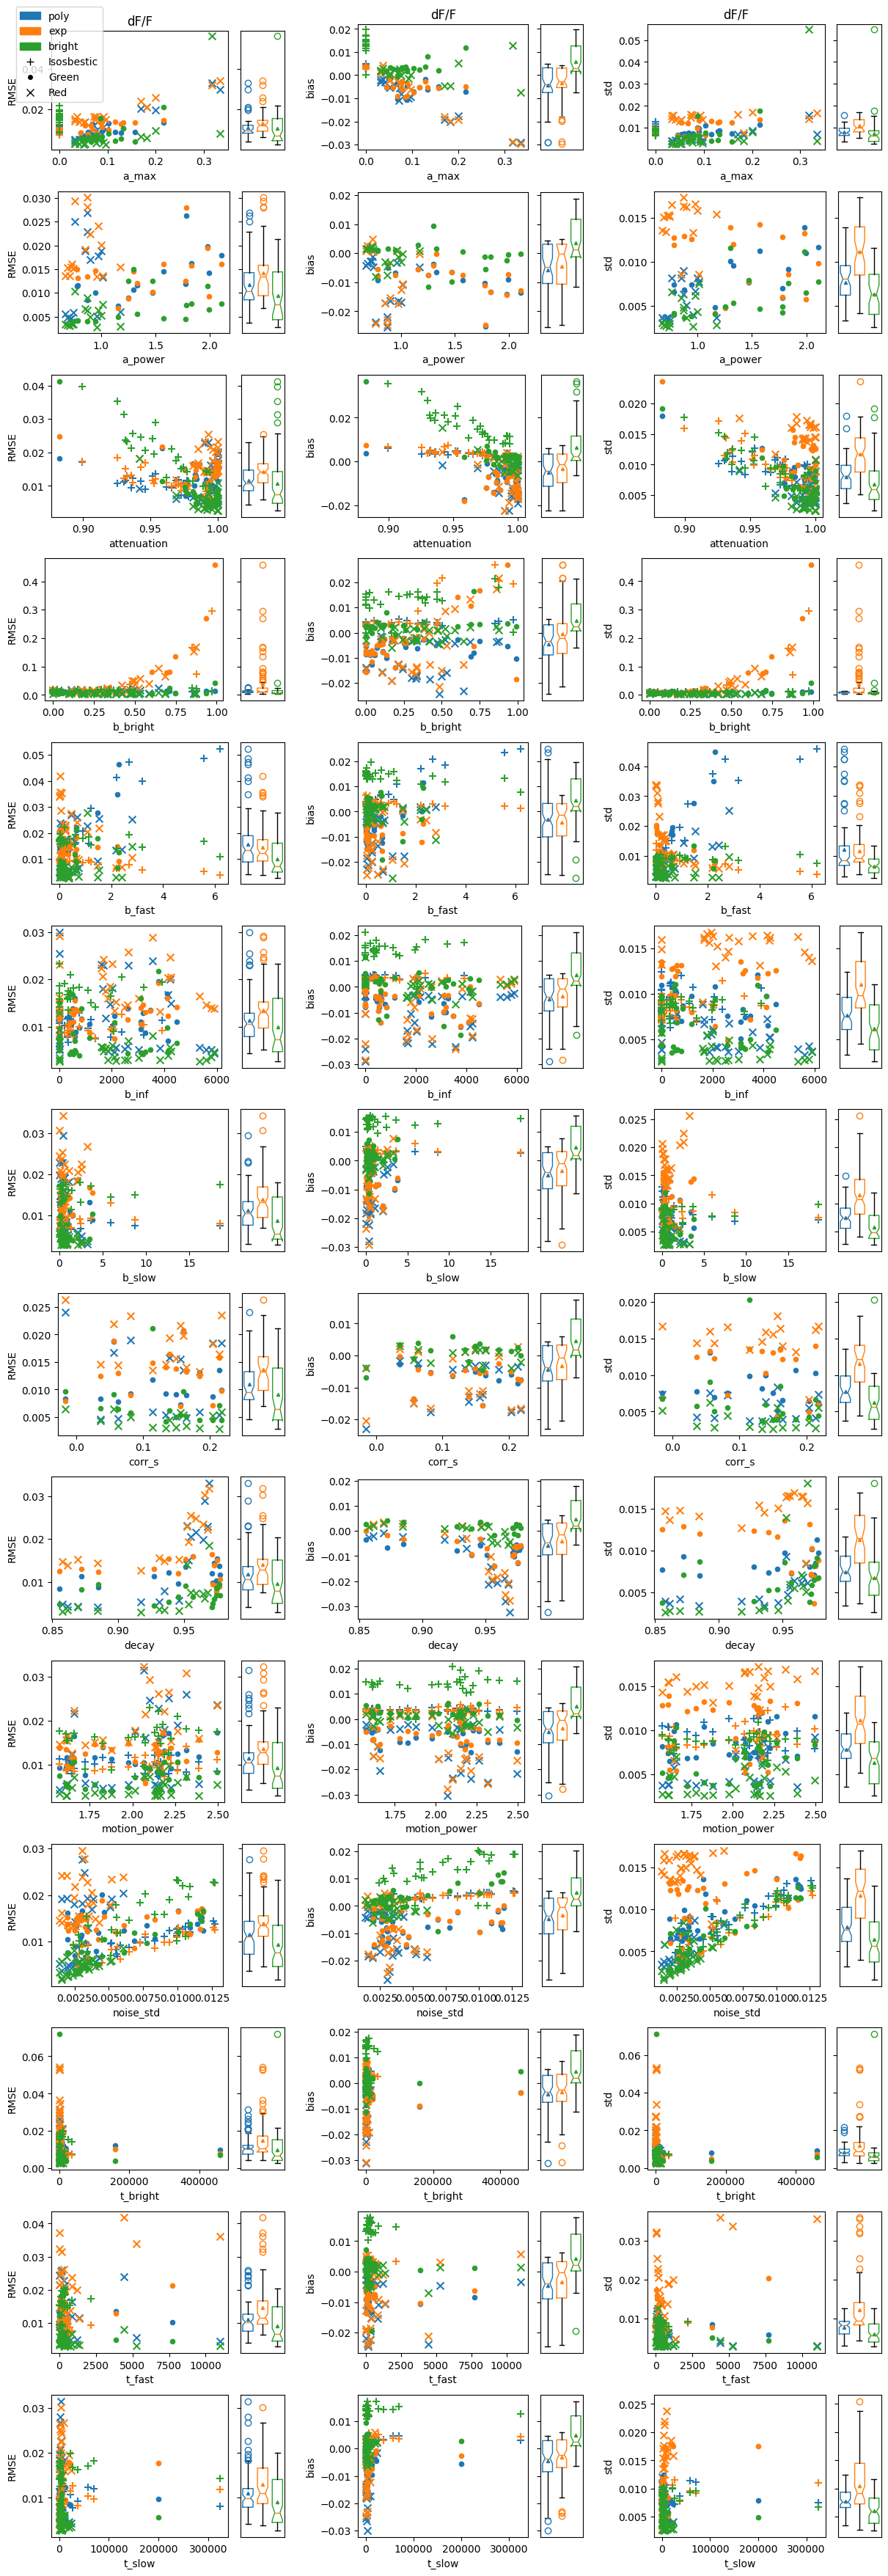

In [8]:
rows = len(results)
fig = plt.figure(layout="constrained", figsize=(12,2.5*rows))
subfigs = fig.subfigures(rows, 3, wspace=0.05)
for row in range(rows):
    params, perf = results[row]
    vary = parents[row].split('/')[-1][5:]
    for col in range(3):
        ax0, ax1 = subfigs[row, col].subplots(1, 2, width_ratios=[4, 1], sharey=True)
        for k in range(len(perf[0])):
            ax0.scatter(params[...,0].ravel(), perf[:,k,col,:,0].ravel(), c=f'C{k}', s=50, marker='+')
            ax0.scatter(params[...,1].ravel(), perf[:,k,col,:,1].ravel(), c=f'C{k}', s=20, marker='o')
            ax0.scatter(params[...,2].ravel(), perf[:,k,col,:,2].ravel(), c=f'C{k}', s=50, marker='x')
            ax1.boxplot(perf[:,k,col].ravel(),
                        positions=[k], widths=.7, showmeans=True, notch=True,
                        boxprops=dict(color=f'C{k}'), flierprops=dict(markeredgecolor=f'C{k}'),
                        meanprops=dict(markerfacecolor=f'C{k}', markeredgecolor=f'C{k}', markersize=3))
            ax1.set_xticks([])
        if col+row==0:
            ax0.legend(handles=[Patch(color='C0', label='poly'),
                                Patch(color='C1', label='exp'),
                                Patch(color='C2', label='bright'),
                                Line2D([], [], color='k', markersize=7, marker='+', linestyle='None', label='Isosbestic'),
                                Line2D([], [], color='k', markersize=4, marker='o', linestyle='None', label='Green'),
                                Line2D([], [], color='k', markersize=7, marker='x', linestyle='None', label='Red')],
                      loc=(-.2,.4))
        ax0.set_xlabel(vary)
        ax0.set_ylabel(['RMSE', 'bias', 'std'][col])
        if row==0:
            ax0.set_title('dF/F')

In [9]:
# RMSE for each method over all simulations
print(np.mean([[results[row][1][:,m,0].mean() for m in (0,1,2)] for row in range(rows)], 0))
print(np.sum([[results[row][1][:,m,0].sum() for m in (0,1,2)] for row in range(rows)], 0))

[0.01165849 0.01565475 0.00958951]
[12.06533871 16.42508929  9.88268613]


In [ ]:
# TukeyBiweight(1) 50 iterations
[0.01165849 0.01565475 0.00958951]
[12.06533871 16.42508929  9.88268613]
# TukeyBiweight(2) 50 iterations
[0.01165849 0.01565475 0.00832579]
[12.06533871 16.42508929  8.53057462]
# HuberT(0.25) 50 iterations
[0.01165849 0.01565475 0.00901595]
[12.06533871 16.42508929  9.30629067]
# HuberT(0.25) 20 iterations
[0.01165849 0.01565475 0.00903013]
[12.06533871 16.42508929  9.32073588]
# median values for all 20 iterations
[0.01165849 0.01565475 0.009519  ]
[12.06533871 16.42508929  9.81912743]
# median values with optim t_fast
[0.01165849 0.01565475 0.00961004]
[12.06533871 16.42508929  9.90852152]
# old
[0.01165849 0.01565475 0.00972095]
[12.06533871 16.42508929 10.03289963]

In [25]:
for parent in parents:
    vary = parent.split('/')[-1][5:]
    qq=[np.array(pd.read_csv(Path(nwb_file).parent / "parameters.csv", delimiter=",", index_col=0)[vary])
          for nwb_file in sorted(glob.glob(f"{parent}/*/*.nwb"))]
    print(vary, np.nanmedian(qq))

a_max 0.0559529356349044
a_power 0.9676361102731483
attenuation 0.990376054752377
b_bright 0.2588575845115088
b_fast 0.20126156478658955
b_inf 1124.1582304257604
b_slow 0.37137221696565875
corr_s 0.14418202106487135
decay 0.9531218852674423
motion_power 2.086924324699142
noise_std 0.0038102636392726
t_bright 2073.122248162862
t_fast 220.42119205670485
t_slow 3712.1658291263648
